In [81]:
import json
import re
import pandas as pd
import urllib
from urllib.request import Request
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import requests
import geopandas
import zipfile
import os
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

In [50]:
otodom = 'https://www.otodom.pl/pl/oferty/sprzedaz/mieszkanie/krakow?page='
pages = []

for page in range(1, 20):
    
    print(f"Downloading page {page}")
    
    try:
        with urllib.request.urlopen(f"{otodom}{page}") as response:
            processed_page = BeautifulSoup(response.read().decode("utf-8"), "html.parser")
            pages.append(processed_page)
    except:
        continue

In [51]:
house_preview = []
house_offers = []

for page in pages:
    house_preview += page.find_all('a', {"data-cy" : "listing-item-link"})

page_prefix = "https://www.otodom.pl"

for house_offer in house_preview:
    page_suffix = house_offer['href']

    try:
        with urllib.request.urlopen(f"{page_prefix}{page_suffix}") as response:
            processed_offer = BeautifulSoup(response.read().decode("utf-8"), "html.parser")
            house_offers.append(processed_offer)

    except:
        continue

In [54]:
houses_data = []

for offer_html in house_offers:
    house_offer = {}
    
    try:
        house_offer['title'] = offer_html.find('h1').text
    except:
        house_offer['title'] = 'None'
    
    try:
        house_offer['price'] = int(offer_html.find('strong', {'aria-label': 'Cena'}).text.replace(' zł', '').replace(' ', ''))
    except:
        house_offer['price'] = -1
            
    try:
        house_offer['price_per_meter'] = int(offer_html.find('div', {'aria-label': 'Cena za metr kwadratowy'}).text.replace(' ', '').replace('zł/m²', '').replace('zł/м²', ''))
    except:
        house_offer['price_per_meter'] = -1

    try:
        house_offer['address'] = offer_html.find('a', {'aria-label': 'Adres'}).text
    except:
        house_offer['address'] = 'None'
        
    try:
        districts = ['Stare Miasto', 'Grzegórzki', 'Prądnik Czerwony', 'Prądnik Biały', 'Krowodrza', 'Bronowice', 'Zwierzyniec', 'Dębniki',
                           'Łagiewniki-Borek Fałęcki', 'Swoszowice', 'Podgórze Duchackie', 'Bieżanów-Prokocim', 'Podgórze', 'Czyżyny', 'Mistrzejowice',
                           'Bieńczyce', 'Wzgórza Krzesławickie', 'Nowa Huta']
        
        for dist in districts:
            if re.search(dist, house_offer['address']) is not None:
                house_offer['district'] = dist.upper()
                break
    except:
        house_offer['district'] = 'None'

    try:
        house_offer['surface'] = float(offer_html.find('div', {'aria-label': 'Powierzchnia'}).select('div.estckra5')[0].text.replace(',', '.').replace(' m²', ''))
    except:
        house_offer['surface'] = -1

    try:
        house_offer['rooms'] = int(offer_html.find('div', {'aria-label': 'Liczba pokoi'}).select('div.estckra5')[0].text)
    except:
        house_offer['rooms'] = -1

    try:
        house_offer['floor'] = offer_html.find('div', {'aria-label': 'Piętro'}).select('div.estckra5')[0].text
    except:
        house_offer['floor'] = 'None'
        
    try:
        house_offer['rent'] = float(offer_html.find('div', {'aria-label': 'Czynsz'}).select('div.estckra5')[0].text.replace(',', '.').replace(' zł', ''))
    except:
        house_offer['rent'] = -1
                            
    try:
        house_offer['balcony_garden_patio'] = offer_html.find('div', {'aria-label': 'Balkon / ogród / taras'}).select('div.estckra5')[0].text
    except:
        house_offer['balcony_garden_patio'] = 'none'
                       
    try:
        house_offer['parking'] = offer_html.find('div', {'aria-label': 'Miejsce parkingowe'}).select('div.estckra5')[0].text
    except:
        house_offer['parking'] = 'none'
                         
    try:
        house_offer['heating'] = offer_html.find('div', {'aria-label': 'Ogrzewanie'}).select('div.estckra5')[0].text
    except:
        house_offer['heating'] = 'none'

    try:
        house_offer['build_time'] = int(offer_html.find('div', {'aria-label': 'Rok budowy'}).select('div.estckra5')[0].text)
    except:
        house_offer['build_time'] = -1

    house_offer['url'] = offer_html.find('link', {'rel': 'alternate'})['href']


    houses_data.append(house_offer)

df = pd.DataFrame.from_dict(houses_data)
df = df[df.price > 0]

In [55]:
df.head()

,title,price,price_per_meter,address,district,surface,rooms,floor,rent,balcony_garden_patio,parking,heating,build_time,url
0,ul. Totus Tuus Tesoro Verde Residence 82m2,943000,11500,"Kraków, Łagiewniki-Borek Fałęcki, ul. Totus Tuus",ŁAGIEWNIKI-BOREK FAŁĘCKI,82.00,4,1/2,-1.00,"balkon, taras",none,gazowe,2022,https://www.otodom.pl/pl/oferta/ul-totus-tuus-...
1,2 pokojowe gotowe do odbioru-Prywatnie,416700,11646,"Kraków, Prądnik Biały, Górka Narodowa, ul. Ste...",PRĄDNIK BIAŁY,35.78,2,2/5,-1.00,balkon,garaż/miejsce parkingowe,miejskie,2022,https://www.otodom.pl/pl/oferta/2-pokojowe-got...
2,"Mieszkanie 25m2, Kraków Kozłówek",325000,13000,"Kraków, Bieżanów-Prokocim, Kozłówek, ul. Spółd...",BIEŻANÓW-PROKOCIM,25.00,1,2/10,180.00,none,none,miejskie,-1,https://www.otodom.pl/pl/oferta/mieszkanie-25m...
3,3-pokojowe mieszkanie 64m2 + ogródek Bez Prowizji,784000,12116,"Kraków, Grzegórzki",GRZEGÓRZKI,64.71,3,parter/5,-1.00,ogródek,garaż/miejsce parkingowe,none,2022,https://www.otodom.pl/pl/oferta/3-pokojowe-mie...
4,1-pokojowe mieszkanie 37m2 + balkon Bez Prowizji,460000,12316,"Kraków, Grzegórzki",GRZEGÓRZKI,37.35,1,1/5,-1.00,balkon,garaż/miejsce parkingowe,none,2022,https://www.otodom.pl/pl/oferta/1-pokojowe-mie...


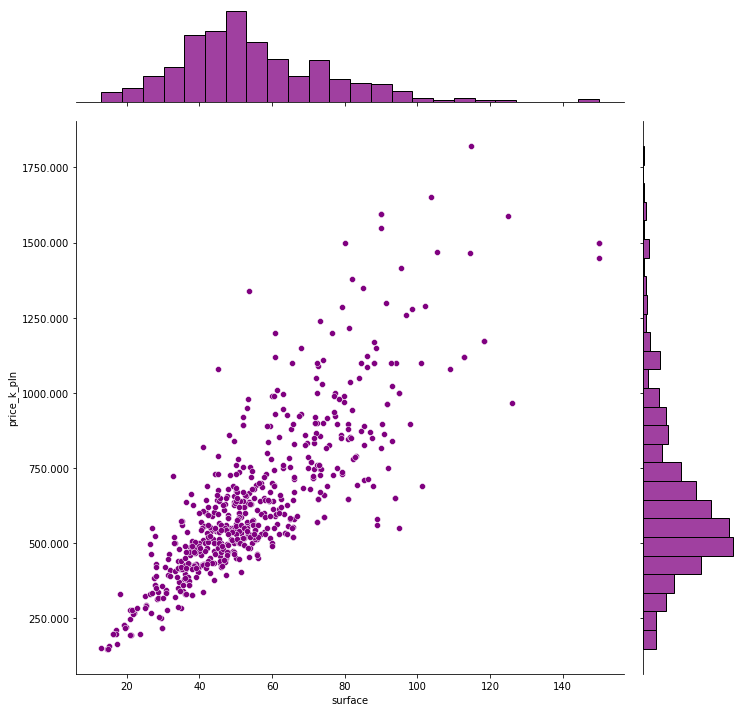

In [87]:
df["price_k_pln"] = df["price"]/1000.0
sns.jointplot(x='surface',y='price_k_pln',data=df[(df["surface"]<200) & (df["price"]<2E6)], 
              height=10, color='purple')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
plt.show()

In [88]:
def read_shape_from_zip(zip_filename, entry_name_regex):
    z = zipfile.ZipFile(zip_filename, mode="r")
    dbf_name = list(filter(
        lambda x: re.match(entry_name_regex + r'.*\.dbf$',
                           os.path.basename(x)),
        z.namelist()
    ))[0]
    z.close()
    return geopandas.read_file(dbf_name, encoding='utf-8', vfs='zip://'+zip_filename)


In [89]:
url = 'https://gis-support.pl/wp-content/uploads/dzielnice_Krakowa.zip'
r = requests.get(url, allow_redirects=True)
open('dzielnice_Krakowa.zip', 'wb').write(r.content)

districts = read_shape_from_zip("dzielnice_Krakowa.zip", "dzielnice_Krakowa")
districts['nazwa'] = districts['nazwa'].str.upper()

In [90]:
df_district = df.groupby('district').size().to_frame()
df_district.columns = ['ilosc']
df_district

,ilosc
district,
BIEŃCZYCE,7
BIEŻANÓW-PROKOCIM,24
BRONOWICE,42
CZYŻYNY,34
DĘBNIKI,81
GRZEGÓRZKI,46
KROWODRZA,48
MISTRZEJOWICE,16
NOWA HUTA,14


In [91]:
df_district_qnty = pd.merge(districts, df_district, left_on='nazwa', right_index=True)
df_district_qnty.sort_values('ilosc',ascending=False)

,objectid,mslink,mapid,id_dzielni,nr_dzielni,powierzchn,nazwa,nazwa_peln,opis,data_aktua,st_area(sh,st_length(,geometry,ilosc
3,4.00,4.00,3013.00,4.00,IV,23418679.00,PRĄDNIK BIAŁY,Dzielnica IV Prądnik Biały,UCHWAŁA NR XCIX/1498/14 RADY MIASTA KRAKOWA,2014-04-01,23418679.08,29388.18,"POLYGON ((561609.805 249100.253, 561714.891 24...",88
7,8.00,8.00,3013.00,8.00,VIII,46188703.00,DĘBNIKI,Dzielnica VIII Dębniki,UCHWAŁA NR XCIX/1502/14 RADY MIASTA KRAKOWA,2014-04-01,46188702.80,40805.96,"POLYGON ((556746.136 238581.515, 556750.361 23...",81
12,13.00,13.00,3013.00,13.00,XIII,25667082.00,PODGÓRZE,Dzielnica XIII Podgórze,UCHWAŁA NR XCIX/1507/14 RADY MIASTA KRAKOWA,2014-04-01,25667081.82,34696.02,"POLYGON ((566385.478 241086.274, 566390.281 24...",77
4,5.00,5.00,3013.00,5.00,V,5619039.00,KROWODRZA,Dzielnica V Krowodrza,UCHWAŁA NR XCIX/1499/14 RADY MIASTA KRAKOWA,2014-04-01,5619038.75,12351.02,"POLYGON ((563475.506 244986.213, 563476.971 24...",48
1,2.00,2.00,3013.00,2.00,II,5845232.00,GRZEGÓRZKI,Dzielnica II Grzegórzki,UCHWAŁA NR XCIX/1496/14 RADY MIASTA KRAKOWA,2014-04-01,5845232.08,11863.16,"POLYGON ((567784.500 244043.139, 567786.287 24...",46
5,6.00,6.00,3013.00,6.00,VI,9559587.00,BRONOWICE,Dzielnica VI Bronowice,UCHWAŁA NR XCIX/1500/14 RADY MIASTA KRAKOWA,2014-04-01,9559586.92,15472.48,"POLYGON ((559680.480 247139.293, 559681.829 24...",42
13,14.00,14.00,3013.00,14.00,XIV,12256767.00,CZYŻYNY,Dzielnica XIV Czyżyny,UCHWAŁA NR XCIX/1508/14 RADY MIASTA KRAKOWA,2014-04-01,12256767.16,20395.75,"POLYGON ((570051.983 246991.812, 570055.463 24...",34
10,11.00,11.00,3013.00,11.00,XI,9540011.00,PODGÓRZE DUCHACKIE,Dzielnica XI Podgórze Duchackie,UCHWAŁA NR XCIX/1505/14 RADY MIASTA KRAKOWA,2014-04-01,9540010.53,17593.09,"POLYGON ((566970.877 237409.550, 566980.142 23...",32
0,1.00,1.00,3013.00,1.00,I,5567646.00,STARE MIASTO,Dzielnica I Stare Miasto,UCHWALA NR XCIX/1495/14 RADY MIASTA KRAKOWA,2014-04-01,5567646.13,11730.27,"POLYGON ((566097.260 244329.716, 566097.477 24...",29
11,12.00,12.00,3013.00,12.00,XII,18473911.00,BIEŻANÓW-PROKOCIM,Dzielnica XII Bieżanów-Prokocim,UCHWAŁA NR XCIX/1506/14 RADY MIASTA KRAKOWA,2014-04-01,18473910.75,23634.83,"POLYGON ((569666.048 239153.774, 569669.023 23...",24


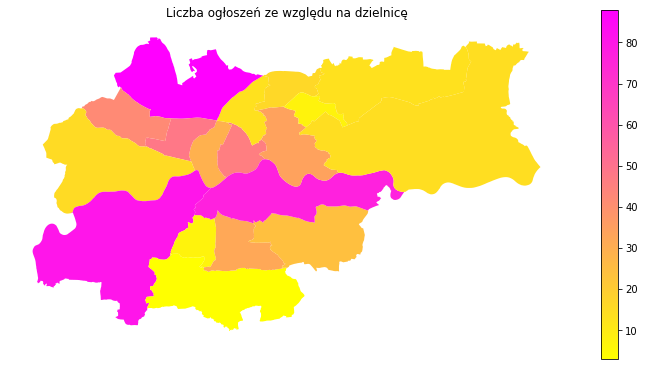

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_qnty.plot(column='ilosc', cmap='spring_r', linewidth=1.5, ax=ax)

vmin, vmax = df_district_qnty['ilosc'].min(), df_district_qnty['ilosc'].max()
sm = plt.cm.ScalarMappable(cmap='spring_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Liczba ogłoszeń ze względu na dzielnicę")
plt.tight_layout()
plt.show()

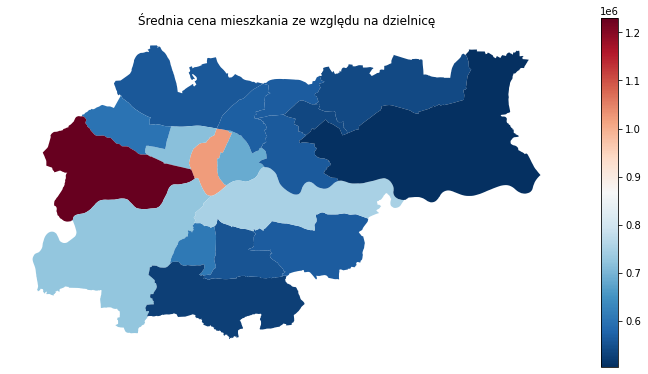

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_mean.plot(column='price', cmap='RdBu_r', linewidth=1.5, ax=ax)

vmin, vmax = df_district_mean['price'].min(), df_district_mean['price'].max()
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Średnia cena mieszkania ze względu na dzielnicę")
plt.tight_layout()
plt.show()

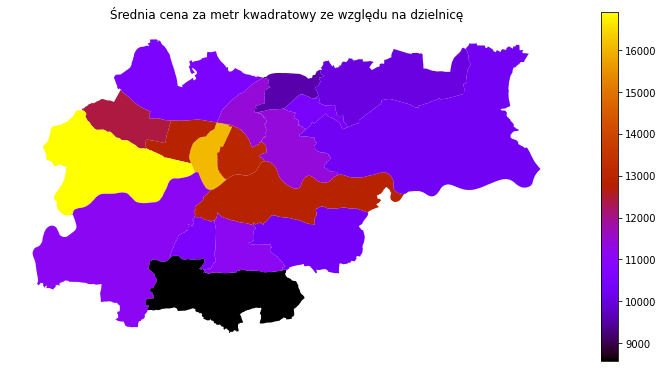

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_mean.plot(column='price_per_meter', cmap='gnuplot', linewidth=1.5, ax=ax)

vmin, vmax = df_district_mean['price_per_meter'].min(), df_district_mean['price_per_meter'].max()
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Średnia cena za metr kwadratowy ze względu na dzielnicę")
plt.tight_layout()
plt.show()

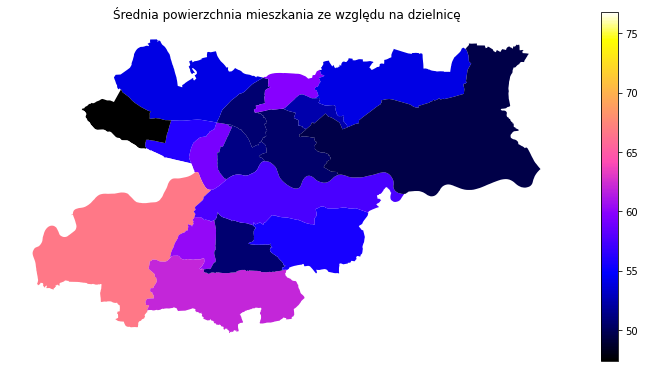

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_mean.plot(column='surface', cmap='gnuplot2', linewidth=1.5, ax=ax)

vmin, vmax = df_district_mean['surface'].min(), df_district_mean['surface'].max()
sm = plt.cm.ScalarMappable(cmap='gnuplot2', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Średnia powierzchnia mieszkania ze względu na dzielnicę")
plt.tight_layout()
plt.show()